## Import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor



## Data preparation

In [3]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [4]:
clean_df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
44984,Pa4iPkLAZ3k,Tableau Tim,Tableau Mobile Device Designer Testing through...,In this short video accompanied by this blog h...,tableau|mobile|device|testing|dashabord|report...,2017-08-30 15:07:16+00:00,3170,27,1,483,hd,False,15,30,2,8,2017
58149,PMSV7CjBuZI,Two Minute Papers,Crumpling Sound Synthesis | Two Minute Papers ...,"The paper ""Crumpling Sound Synthesis"" is avail...",two minute papers|károly zsolnai|károly zsolna...,2016-12-17 14:59:22+00:00,13417,532,33,233,hd,True,14,17,5,12,2016
46299,_n-GthGQw7o,MLOps.community,The Shipyard: Lessons Learned While Building a...,"MLOps Coffee Sessions #91 with Joseph Haaga, T...",MLOps|MLOps community|Build vs Buy|Building an...,2022-04-07 13:00:29+00:00,687,25,2,2400,hd,False,13,7,3,4,2022
26843,MAOG1qvE4Bk,Databricks,Introduction to Data Streaming on the Lakehouse,Streaming is the future of all data pipelines ...,Databricks,2023-07-25 23:10:41+00:00,2490,16,0,2082,hd,False,23,25,1,7,2023
22448,xAySNOTLCB8,deeplizard,Buy ZCash with Litecoin using the Shifty butto...,Shows how to buy ZCash with Litecoin in the Ja...,cryptocurrency|crypto|currency|money|blockchai...,2017-09-10 03:23:39+00:00,238,3,2,204,hd,False,3,10,6,9,2017


## Feature engineering

In [5]:
X = clean_df[['viewCount','likeCount', 'commentCount', 'hour', 'day', 'month', 'year']]
# Tạo cột nhãn, ví dụ: nếu viewCount lớn hơn một ngưỡng nào đó, coi video đó là phổ biến
threshold_viewCount = clean_df['viewCount'].quantile(0.7)
clean_df['isTrending'] = (clean_df['viewCount'] > threshold_viewCount).astype(int)
y = clean_df['isTrending']

In [6]:
clean_df.sample(5)


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year,isTrending
10869,5pYyNm6DUj8,Shashank Kalanithi,Get a Data Science or Data Analyst Role (feat....,Learn how to stand out in the analytics job hu...,(notag),2021-11-03 16:15:32+00:00,12277,562,22,4781,hd,False,16,3,2,11,2021,1
42734,7Hn1qbxbHF0,itversity,Setup Development Enviroment Using Python - 04...,Connect with me or follow me at\nhttps://www.l...,(notag),2018-11-25 23:37:59+00:00,190,2,0,198,hd,False,23,25,6,11,2018,0
18858,0Czwsywghuo,DataCamp,Python Tutorial: Introduction to Conversationa...,Want to learn more? Take the full course at h...,Software|Conversational|Python|Chatbots|DataCa...,2020-03-30 04:52:04+00:00,163,1,0,215,hd,False,4,30,0,3,2020,0
49308,A3qzF-iuVBE,RADACAD,Difinity,"Difinity: The largest Microsoft Data Platform,...",conference|database|sqlserver|powerbi|analytic...,2016-11-28 09:31:22+00:00,328,0,0,71,hd,False,9,28,0,11,2016,0
45511,n0dAWJX1-oM,Automata Learning Lab,Quick Introduction to Python Syntax,(nodescription),(notag),2022-10-01 11:10:02+00:00,194,11,0,36,hd,False,11,1,5,10,2022,0


## Training model

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y ,test_size=0.2)
model = LogisticRegression(solver = 'liblinear',max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Evaluation

In [8]:
model.score(X_valid,y_valid)

0.9997501457483134

## Prediction

In [9]:
y_pred = model.predict(X_valid)

In [10]:
precision_score(y_valid,y_pred), recall_score(y_valid,y_pred)

(0.9991712707182321, 1.0)

In [11]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8390
           1       1.00      1.00      1.00      3617

    accuracy                           1.00     12007
   macro avg       1.00      1.00      1.00     12007
weighted avg       1.00      1.00      1.00     12007



##### Decision Tree

In [17]:
decision_Tree = DecisionTreeRegressor()
decision_Tree.fit(X_train,y_train)


DecisionTreeRegressor()

In [15]:
decision_Tree.score(X_valid,y_valid)

1.0

# TEMP


In [13]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
seed = 2023
models = [
    Lasso(random_state=seed),
    ElasticNet(random_state=seed),
    Ridge(random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    RandomForestRegressor(random_state=seed),
    ExtraTreesRegressor(random_state=seed),
    AdaBoostRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed)
]

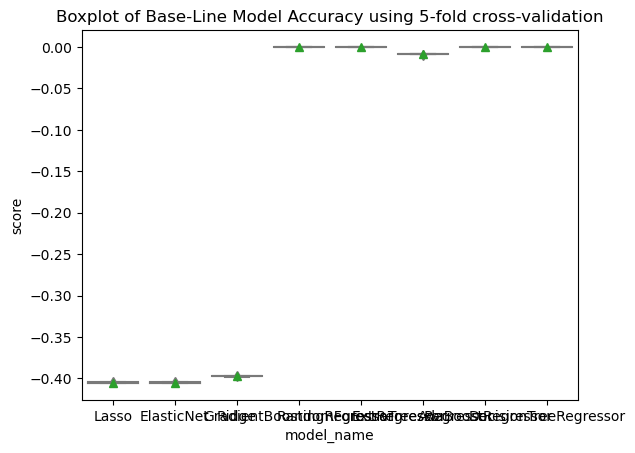

,Mean,Standard Deviation
model_name,,
AdaBoostRegressor,0.000000,0.000000e+00
DecisionTreeRegressor,0.000000,0.000000e+00
RandomForestRegressor,-0.000004,4.059050e-06
GradientBoostingRegressor,-0.000011,4.550672e-10
ExtraTreesRegressor,-0.009047,8.558712e-04
Ridge,-0.397486,3.402875e-04
ElasticNet,-0.404874,3.889604e-04
Lasso,-0.404913,3.932607e-04


In [14]:
def generate_baseline_result(models, X, y, metrics, cv=5, plot_result=False):
    # define k-fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])
    
    mean = cv_df.groupby('model_name')['score'].mean()
    std = cv_df.groupby('model_name')['score'].std()
    
    baseline_results = pd.concat([mean,std],axis =1, ignore_index=True)
    baseline_results.columns =['Mean','Standard Deviation']
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace = True)
    
    if plot_result:
        sns.boxplot(x ='model_name',y = 'score', data = cv_df, color ='lightblue',showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validation')
        plt.show()
    
    return baseline_results

# Metric: https://scikit-learn.org/stable/modules/model_evaluation.html
generate_baseline_result(models, X_train, y_train, metrics='neg_mean_absolute_error',cv=5,plot_result =True )